In [13]:
import pandas as pd
import numpy as np

In [12]:
# Import data "book_Sales.csv"
df = pd.read_csv("./book_sales.csv", index_col='Date', parse_dates=['Date']).drop('Paperback', axis=1)
df.head()


,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


### Part01 Linear Regression with Time Series
#### Tip1: Ttwo kinds of features unique to time series: time-step features + lag features. 

#### 1.1 Time-step features 
They are features we can derive directly from the time index. The most basic time-step feature is the time dummy, which counts off time steps in the series from beginning to end.


In [44]:
df['Time'] = np.arange(len(df.index))
# df['Time'] = np.arange(df.iloc[:, 0])

In [48]:
df.iloc[0, :]

Hardcover    139
Time           0
Name: 2000-04-01 00:00:00, dtype: int64

linkcode
Linear regression with the time dummy produces the model: 

target = weight * time + bias

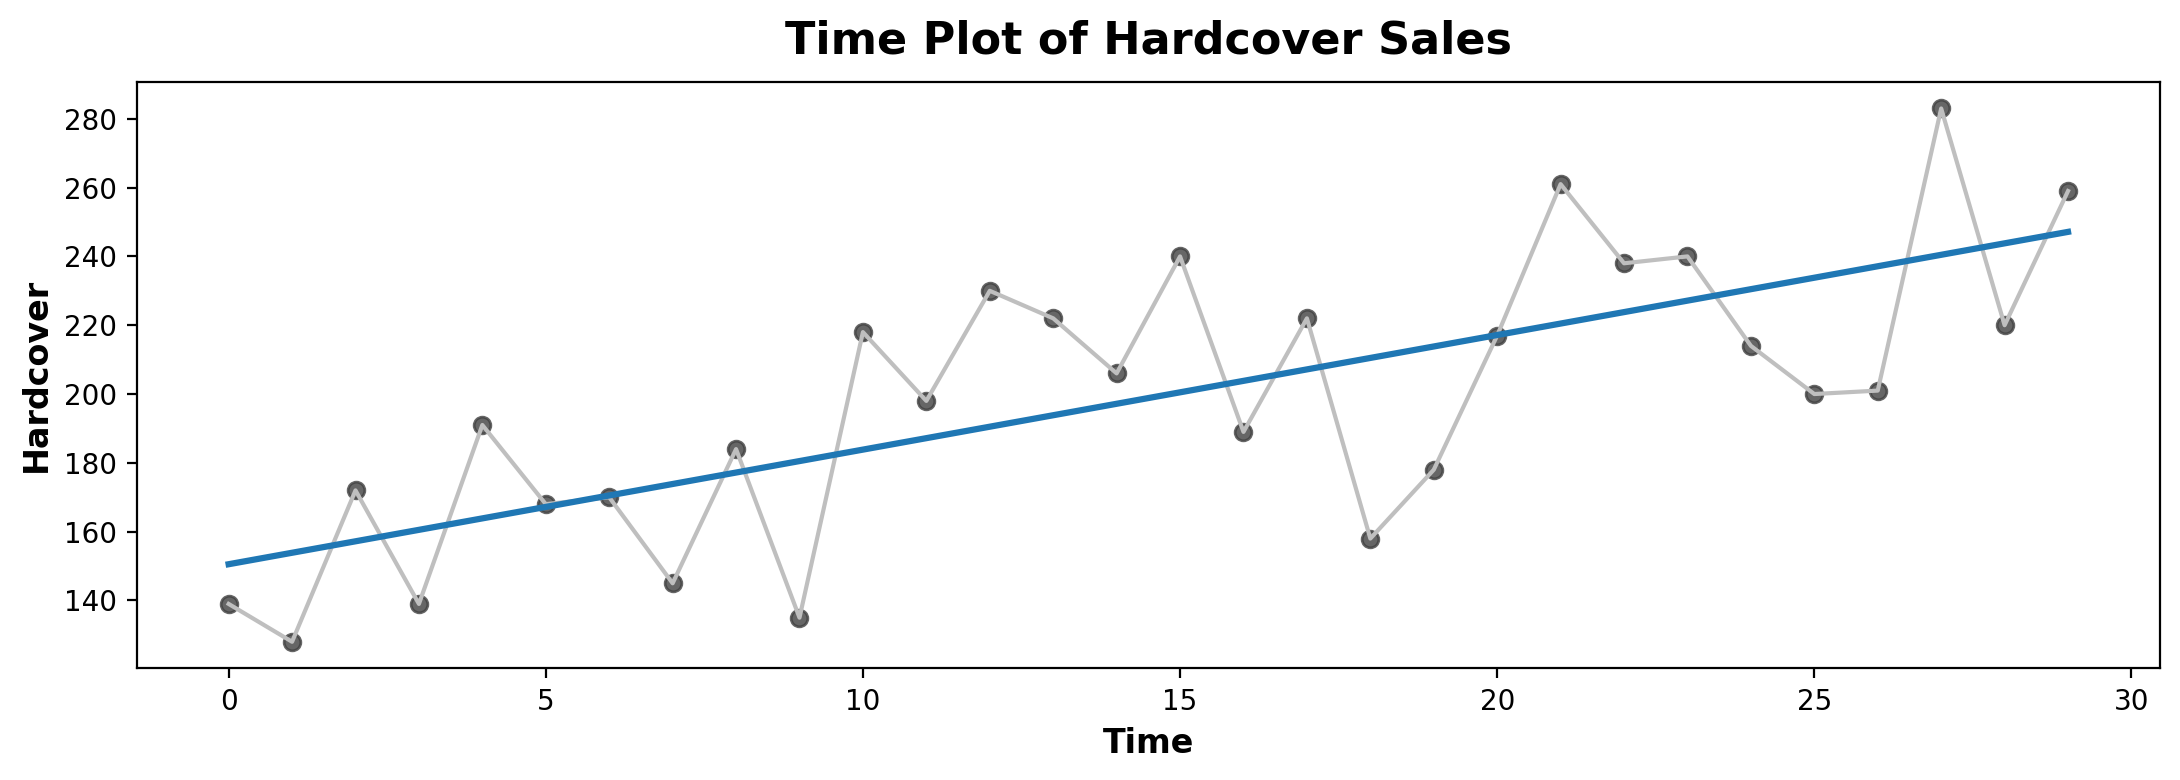

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configure matplotlib settings directly
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'
# ^designed for Jupyter notebooks to render high-resolution images, so it might not work if you're running this outside of a notebook.

# Create a figure and axis
fig, ax = plt.subplots()

# Plot data using Matplotlib
ax.plot('Time', 'Hardcover', data=df, color='0.75')

# Add a regression plot using Seaborn
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))

# Set the title
ax.set_title('Time Plot of Hardcover Sales');

#### Part02 Lag features
To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too.

In [58]:
df['Lag_1'] = df['Hardcover'].shift(1)
# Basic Syntax of df_reindex
# df_reindexed = df.reindex(index=new_index, columns=new_columns)
# It allows you to reorder your rows/columns

# Handling Lagged or Shifted Data: In your example, where you're 
# creating a lagged version of a column, reordering columns helps 
# in immediately visualizing the relationship between the original data 
# and its lagged version. This can be particularly useful when checking 
# for trends or patterns over time.
df = df.reindex(columns=['Hardcover', 'Lag_1'])
df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Linear regression with a lag feature produces the model:

target = weight * lag + bias

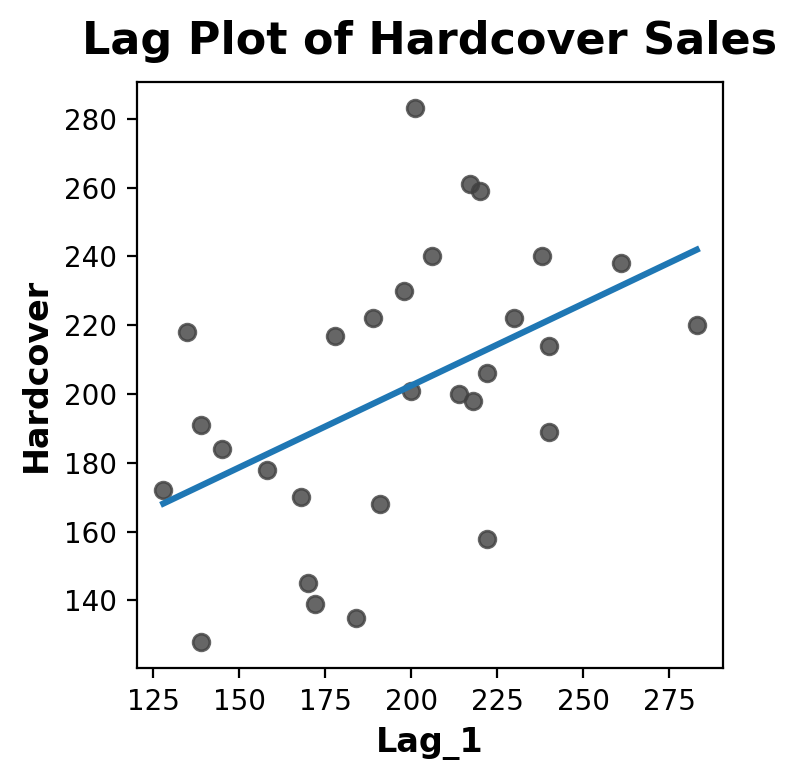

In [59]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
# This ensures that the units are equally scaled on both the x and y axes, so a unit distance
#  on the x-axis is the same as on the y-axis.
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

You can see from the lag plot that sales on one day (Hardcover) are correlated with sales from the previous day (Lag_1). When you see a relationship like this, you know a lag feature will be useful.

### Example - Tunnel Traffic¶

Tunnel Traffic is a time series describing the number of vehicles traveling through the Baregg Tunnel in Switzerland each day from November 2003 to November 2005. In this example, we'll get some practice applying linear regression to time-step features and lag features.



In [60]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
tunnel = pd.read_csv("./tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


### Time-step feature

Provided the time series doesn't have any missing dates, we can create a time dummy by counting out the length of the series.

In [61]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


The procedure for fitting a linear regression model follows the standard steps for scikit-learn.

In [63]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

The model actually created is (approximately): Vehicles = 22.5 * Time + 98176. Plotting the fitted values over time shows us how fitting linear regression to the time dummy creates the trend line defined by this equation.

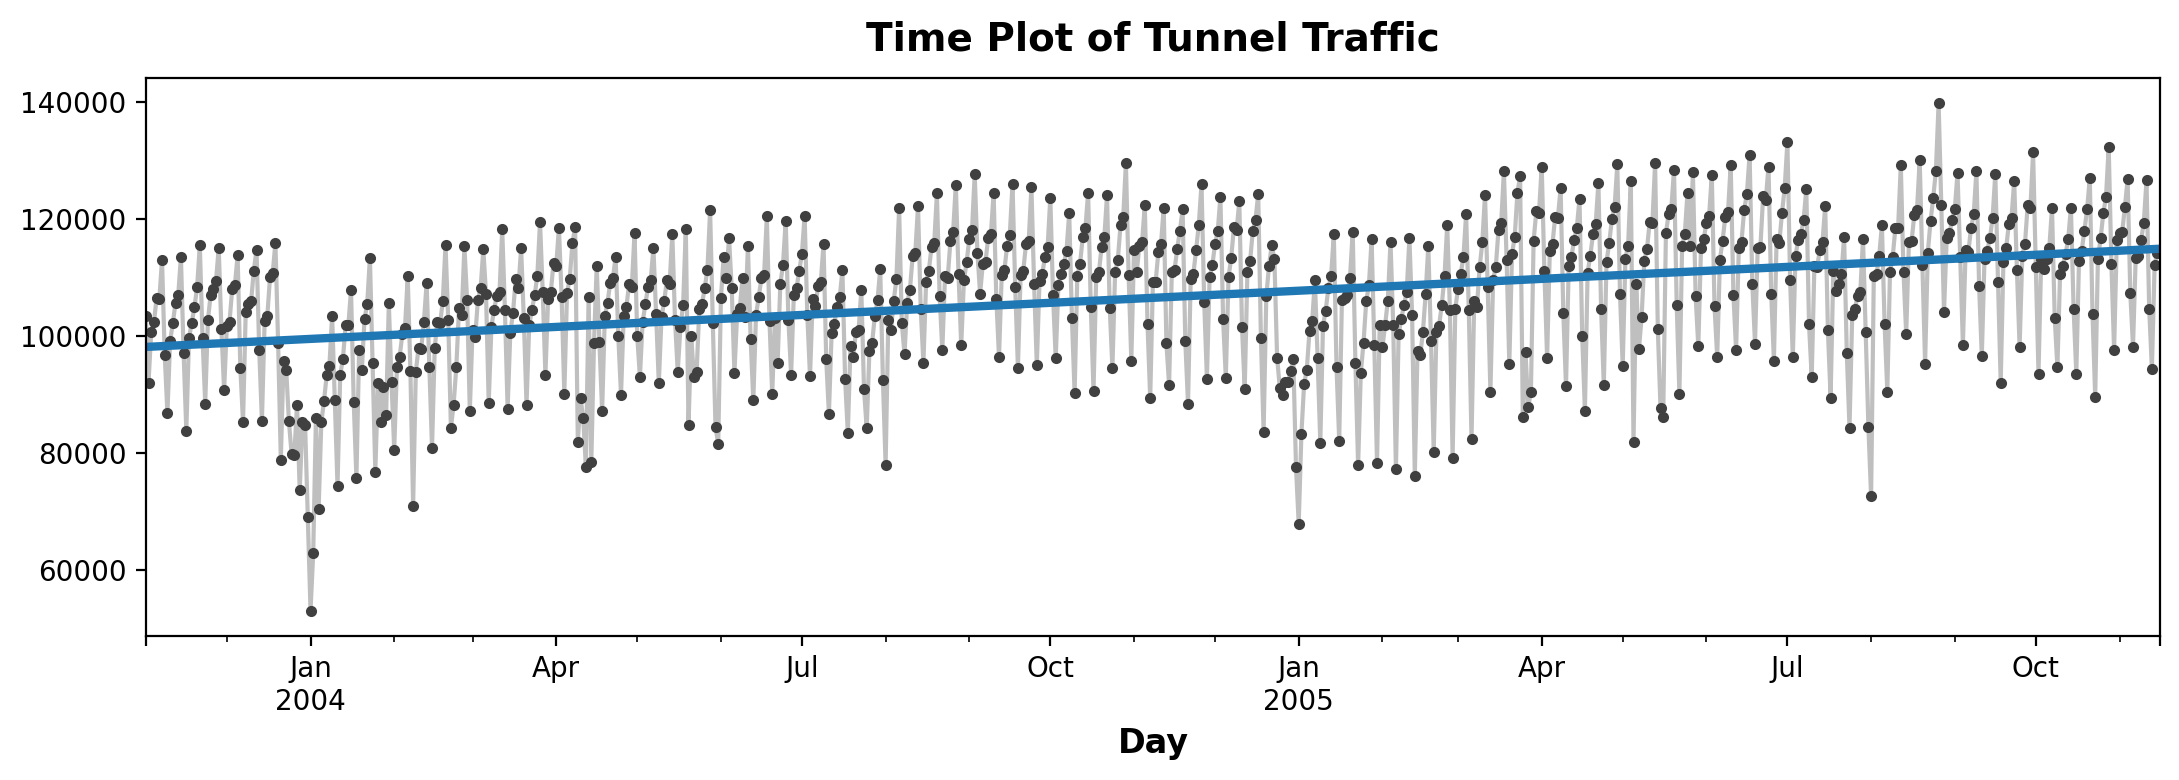

In [69]:
ax = y.plot(**plot_params)  
# The **plot_params in the code snippet refers to a dictionary of keyword 
# arguments that can be passed to the plot() function. This allows for 
# customization of the plot's appearance, such as setting the color, 
# linestyle, marker type, labels, etc.

# Would be equivalent to:
# ax = y.plot(color='blue', linestyle='--', marker='o', label='Actual Traffic')

ax = y_pred.plot(ax=ax, linewidth=3)
#  The ax=ax part means that the second plot (of y_pred) is being drawn on the same 
# axes (ax) as the first plot (of y). It might be fine to omit.

ax.set_title('Time Plot of Tunnel Traffic');

### Lag feature

Pandas provides us a simple method to lag a series, the shift method.

In [70]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


When creating lag features, we need to decide what to do with the missing values produced. Filling them in is one option, maybe with 0.0 or "backfilling" with the first known value. Instead, we'll just drop the missing values, making sure to also drop values in the target from corresponding dates.

In [71]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

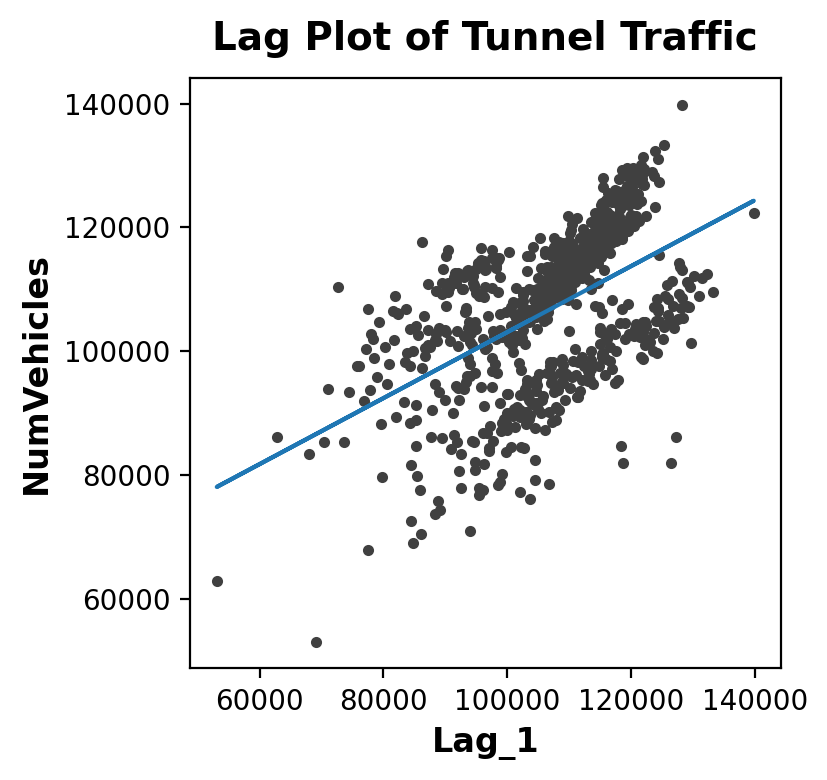

In [72]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

The lag plot shows us how well we were able to fit the relationship between the number of vehicles one day and the number the previous day.

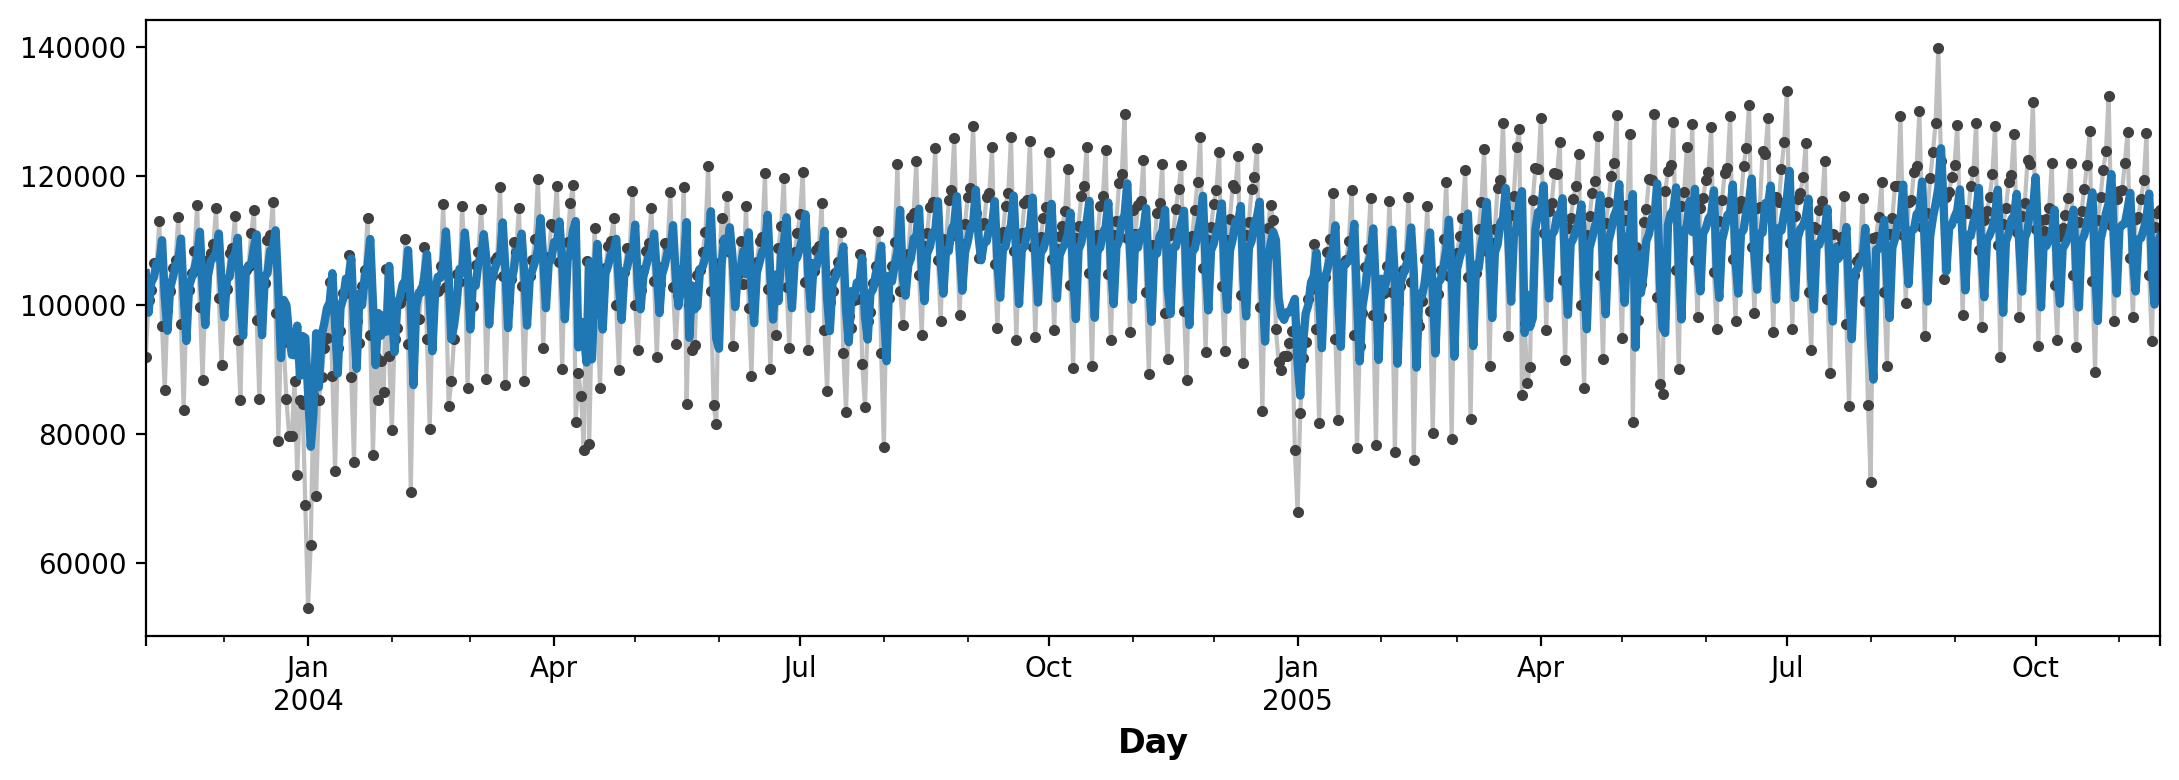

In [74]:
ax = y.plot(**plot_params)
ax = y_pred.plot(linewidth=3)

The following time plot shows us how our forecasts now respond to the behavior of the series in the recent past.

The best time series models will usually include some combination of time-step features and lag features. Over the next few lessons, we'll learn how to engineer features modeling the most common patterns in time series using the features from this lesson as a starting point.